In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Our functions
from utils import mnist_square_grid

In [12]:
# Check if torch is running on GPU
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(0))

GeForce MX150


In [3]:
# Get MNIST data
IMAGE_SIZE = 64
mnist_data = datasets.MNIST(
    root='data/mnist/', 
    download=True,
   transform=transforms.Compose([
       transforms.Resize(IMAGE_SIZE),
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
   ])
)
img_channels = 1

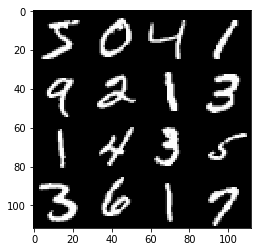

In [4]:
# Look at it!
plt.imshow(mnist_square_grid(mnist_data.data[0:16].numpy()), cmap='gray')

In [5]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, img_channels, init_channels, kernel_size=4, stride=2, padding=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, init_channels, kernel_size, stride, padding),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels, init_channels*2, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*2, init_channels*4, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*4, init_channels*8, kernel_size, stride, padding),
            nn.BatchNorm2d(init_channels*8),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(init_channels*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [6]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, img_channels, target_channels, init_size, kernel_size=4, stride=2, padding=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(init_size, target_channels * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(target_channels * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 8, target_channels * 4, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 4, target_channels * 2, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels * 2, target_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(target_channels),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(target_channels, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [8]:
# Create networks and apply weight initializers
disc = Discriminator(img_channels, 64)
disc.apply(weights_init)
print(disc)

gen = Generator(img_channels, 64, 100)
gen.apply(weights_init)
print(gen)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=Fa

In [9]:
d_loss = nn.BCELoss()

batch_size = 32
lr = 0.0002
example_noise = torch.randn(batch_size, 100, 1, 1)
real_label = 1
fake_label = 1

# setup optimizer
optimizer_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

In [22]:
loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
for i, data in enumerate(loader):
    disc.zero_grad()
    batch = data[0]
    batch_size = batch.shape[0]
    batch_labels = torch.full((batch_size,), real_label)
    
    disc_output = disc(batch)
    disc_err_real = d_loss(disc_output, label)
    disc_err_real.backward()
    
    
    
    
    if i % 100 == 0:
        print(disc_err_real)

tensor(1.5856, grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.5664, grad_fn=<BinaryCrossEntropyBackward>)


KeyboardInterrupt: 

In [24]:
i

118